# Whale detection

In [9]:
from PIL import Image

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
import fastai
fastai.__version__

'1.0.41'

In [3]:
from zen_dataset import *
from zen_dataset.utils import *

In [4]:
class Reader():
    def __init__(self, path):
        self.path = path
    def __call__(self, item):
        image_path = f'{self.path}/{item}'
        image = open_image(image_path)
        tensor = image2tensor(image)
        return imagenet_normalize(tensor)

In [5]:
train_ds = Dataset(pd.read_csv('data/train.csv').Image, Reader('data/train-224'), lambda item: 0)

fns = [p.name for p in paths_to_files_in('data/test-224')]
test_ds = Dataset(fns, Reader('data/test-224'), lambda item: 0)

In [6]:
NUM_WORKERS = 12
BS = 64

train_dl = DataLoader(train_ds, batch_size=BS, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=BS, num_workers=NUM_WORKERS)

In [7]:
batch = next(iter(train_dl))
type(batch)

list

In [8]:
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [9]:
data = DataBunch(train_dl, test_dl)

In [10]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [11]:
def loss_fn(preds, targs, class_idxs): return L1Loss()(preds, targs.squeeze())
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [12]:
state_dict = torch.load('data/train-224/models/fluke_detector.pth')
learn.model.load_state_dict(state_dict['model'])

In [14]:
train_preds, _ = learn.get_preds(DatasetType.Train)
test_preds, _ = learn.get_preds(DatasetType.Valid)

In [15]:
def extract_bbox(fn, scaled_coords, directory='train'):
    im = open_image(f'data/{directory}/{fn}')
    width, heigth = im.size
    ary = np.asarray(im)
    y_up_left, x_up_left, y_low_right, x_low_right = ((scaled_coords + 1)  / 2).clamp(0,1).numpy()
    y_up_left = np.round(y_up_left * heigth)
    x_up_left = np.round(x_up_left * width)

    y_low_right = np.round(y_low_right * heigth)
    x_low_right = np.round(x_low_right * width)

    y_up_left, x_up_left, y_low_right, x_low_right = list(map(int, [y_up_left, x_up_left, y_low_right, x_low_right]))
    return ary[y_up_left:y_low_right, x_up_left:x_low_right]

In [16]:
!rm -rf data/train-extracted-224
!rm -rf data/test-extracted-224

!mkdir data/train-extracted-224
!mkdir data/test-extracted-224

In [17]:
%%time

SZ = 224
for i, fn in enumerate(train_ds.items):
    ary = extract_bbox(fn, train_preds[i])
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/train-extracted-{SZ}/{fn}')

d4cb9d6e4.jpg - failed to extract bbox
CPU times: user 9min 34s, sys: 4.11 s, total: 9min 38s
Wall time: 9min 47s


In [18]:
ims = []
for fn in ['d4cb9d6e4.jpg']:
    ims.append(np.asarray(open_image(f'data/train-224/{fn}')))

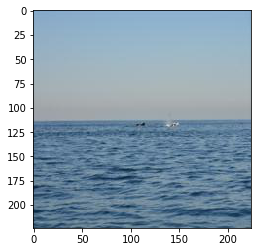

In [19]:
plt.imshow(montage(np.stack(ims), multichannel=True))

In [23]:
train_ds.items[0]

'0000e88ab.jpg'

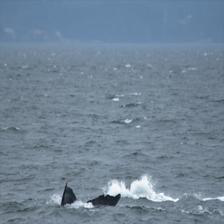

In [22]:
open_image('data/train-224/b370e1339.jpg')

In [20]:
%%time

SZ = 224
for i, fn in enumerate(test_ds.items):
    ary = extract_bbox(fn, test_preds[i], 'test')
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/test-extracted-{SZ}/{fn}')

6a72d84ca.jpg - failed to extract bbox
CPU times: user 3min 5s, sys: 1.47 s, total: 3min 6s
Wall time: 3min 9s


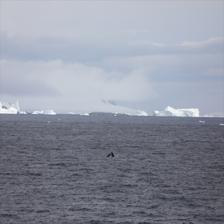

In [21]:
open_image('data/test-224/6a72d84ca.jpg')

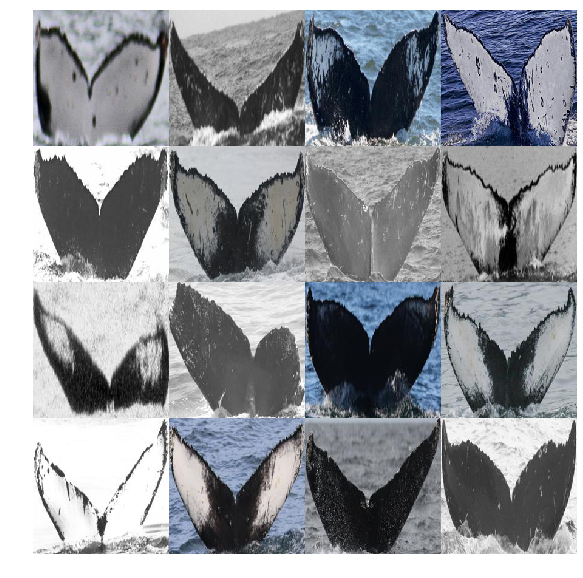

In [24]:
paths = paths_to_files_in('data/train-extracted-224/')
np.random.shuffle(paths)

ims = []
for path in paths[:16]: ims.append(np.asarray(open_image(path)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [25]:


SZ = 448

!rm -rf data/train-extracted-{SZ}
!rm -rf data/test-extracted-{SZ}

!mkdir data/train-extracted-{SZ}
!mkdir data/test-extracted-{SZ}



In [26]:
%%time

for i, fn in enumerate(train_ds.items):
    ary = extract_bbox(fn, train_preds[i])
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/train-extracted-{SZ}/{fn}')

d4cb9d6e4.jpg - failed to extract bbox
CPU times: user 12min 13s, sys: 4.86 s, total: 12min 18s
Wall time: 12min 27s


In [27]:
%%time

for i, fn in enumerate(test_ds.items):
    ary = extract_bbox(fn, test_preds[i], 'test')
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/test-extracted-{SZ}/{fn}')

6a72d84ca.jpg - failed to extract bbox
CPU times: user 3min 54s, sys: 1.61 s, total: 3min 55s
Wall time: 3min 58s
